In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import Binarizer
import tensorflow as tf

def Hinton_bias_init(x, x_min=0, level_gap=1):
    '''
    Initialize visible biases based on the average value in the dataset.
    Hinton, "A Practical Guide to Training Restricted Boltzmann Machines"
    x: data array
    x_min: minimum value of x
    level_gap: difference between max and min values in x
    '''
    xmean = np.mean(x, axis=0)
    S = 1e-4
    x1, x2 = x_min + S, 1 - S
    xmean = np.clip(xmean, x1, x2)
    return (1 / level_gap) * np.clip(np.log(xmean - x_min) - np.log(1 - xmean), -300, 300)

class RBM:
    def __init__(self, n_visible, n_hidden, initial_learning_rate=0.01, decay_rate=0.95, batch_size=10, n_iter=20, optimizer='sgd', cd_steps=1, n_jobs=-1):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.initial_learning_rate = initial_learning_rate
        self.learning_rate = initial_learning_rate
        self.decay_rate = decay_rate
        self.batch_size = batch_size
        self.n_iter = n_iter
        self.optimizer = optimizer.lower()
        self.cd_steps = cd_steps
        self.weights = np.random.randn(n_visible, n_hidden) * 0.1
        self.visible_bias = np.zeros(n_visible)
        self.hidden_bias = np.zeros(n_hidden)
        self.opt = self._choose_optimizer()
        self.learning_rate_history = []
        self.log_likelihood_history = []

    def _choose_optimizer(self):
        if self.optimizer == 'sgd':
            self.learning_rate = 1.0
            self.decay_rate = 0.95
            return tf.optimizers.SGD(self.learning_rate)
        elif self.optimizer == 'rmsprop':
            self.learning_rate = 0.05
            self.decay_rate = 0.0
            return tf.optimizers.RMSprop(self.learning_rate)
        elif self.optimizer == 'adam':
            self.learning_rate = 0.001
            self.decay_rate = 0.0
            return tf.optimizers.Adam(self.learning_rate)
        else:
            raise ValueError("Unsupported optimizer. Choose from 'sgd', 'rmsprop', 'adam'.")

    def _update_learning_rate(self, epoch):
        self.learning_rate = self.initial_learning_rate * (self.decay_rate ** epoch)
        self.opt.learning_rate.assign(self.learning_rate)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _sample_prob(self, prob):
        return np.random.binomial(1, prob)

    def contrastive_divergence(self, input_data):
        positive_hidden_probs = self._sigmoid(np.dot(input_data, self.weights) + self.hidden_bias)
        positive_hidden_activations = self._sample_prob(positive_hidden_probs)

        for step in range(self.cd_steps):
            negative_visible_probs = self._sigmoid(np.dot(positive_hidden_activations, self.weights.T) + self.visible_bias)
            negative_visible_activations = self._sample_prob(negative_visible_probs)
            negative_hidden_probs = self._sigmoid(np.dot(negative_visible_activations, self.weights) + self.hidden_bias)
            positive_hidden_activations = self._sample_prob(negative_hidden_probs)

        return input_data, positive_hidden_probs, positive_hidden_activations, negative_visible_probs, negative_hidden_probs

    def fit(self, data):
        # Initialize visible biases using Hinton's method
        self.visible_bias = Hinton_bias_init(data)
        for epoch in range(self.n_iter):
            np.random.shuffle(data)
            batches = [data[k:k + self.batch_size] for k in range(0, data.shape[0], self.batch_size)]
            
            # Update learning rate
            self._update_learning_rate(epoch)
            self.learning_rate_history.append(self.learning_rate)

            for batch in batches:
                input_data, positive_hidden_probs, positive_hidden_activations, negative_visible_probs, negative_hidden_probs = self.contrastive_divergence(batch)
                
                positive_grad = np.dot(input_data.T, positive_hidden_probs)
                negative_grad = np.dot(negative_visible_probs.T, negative_hidden_probs)
                
                self.weights += self.learning_rate * (positive_grad - negative_grad) / self.batch_size
                self.visible_bias += self.learning_rate * np.mean(input_data - negative_visible_probs, axis=0)
                self.hidden_bias += self.learning_rate * np.mean(positive_hidden_probs - negative_hidden_probs, axis=0)
            log_likelihood = self.compute_log_likelihood(data)
            print(f"Epoch {epoch + 1}/{self.n_iter}, Log-Likelihood: {log_likelihood}, lr = {self.opt.learning_rate.numpy()}")
            self.log_likelihood_history.append(log_likelihood)

    def transform(self, data):
        hidden_probs = self._sigmoid(np.dot(data, self.weights) + self.hidden_bias)
        return hidden_probs

    def compute_log_likelihood(self, data):
        visible_bias_term = np.dot(data, self.visible_bias)
        hidden_bias_term = np.sum(np.log(1 + np.exp(np.dot(data, self.weights) + self.hidden_bias)), axis=1)
        log_likelihood = np.mean(visible_bias_term + hidden_bias_term)
        return log_likelihood

    def plot_learning_rate(self):
        plt.plot(self.learning_rate_history)
        plt.title("Learning Rate Over Time")
        plt.xlabel("Epoch")
        plt.ylabel("Learning Rate")
        plt.show()

    def plot_log_likelihood(self):
        plt.plot(self.log_likelihood_history)
        plt.title("Log-Likelihood Over Time")
        plt.xlabel("Epoch")
        plt.ylabel("Log-Likelihood")
        plt.show()


/tmp/ipykernel_106106/3921651979.py:46: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 1/50, Log-Likelihood: -55.43789793733931, lr = 1.0
Epoch 2/50, Log-Likelihood: -40.0887665165611, lr = 0.949999988079071
Epoch 3/50, Log-Likelihood: -56.76364228624484, lr = 0.9024999737739563
Epoch 4/50, Log-Likelihood: -40.49850681873699, lr = 0.8573750257492065
Epoch 5/50, Log-Likelihood: -53.90586551322034, lr = 0.8145062327384949
Epoch 6/50, Log-Likelihood: -41.94093302001812, lr = 0.7737809419631958
Epoch 7/50, Log-Likelihood: -49.28032711602704, lr = 0.7350918650627136
Epoch 8/50, Log-Likelihood: -42.87096904502889, lr = 0.6983373165130615
Epoch 9/50, Log-Likelihood: -51.176991172829915, lr = 0.6634204387664795
Epoch 10/50, Log-Likelihood: -42.08751358305339, lr = 0.6302493810653687
Epoch 11/50, Log-Likelihood: -44.61322745814002, lr = 0.5987369418144226
Epoch 12/50, Log-Likelihood: -51.532414204478464, lr = 0.5688000917434692
Epoch 13/50, Log-Likelihood: -48.73624977427397, lr = 0.5403600931167603
Epoch 14/50, Log-Likelihood: -54.27930176297013, lr = 0.5133420825004578
Ep

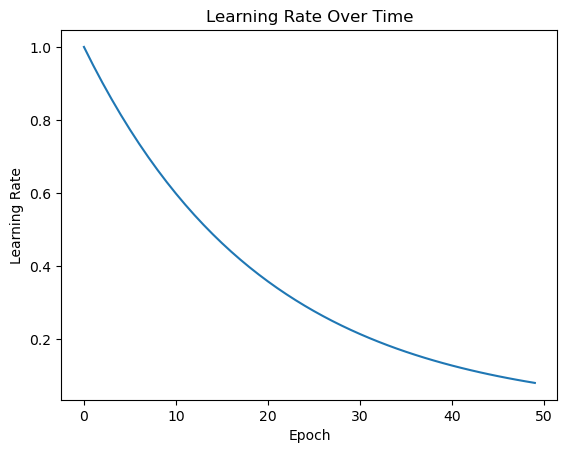

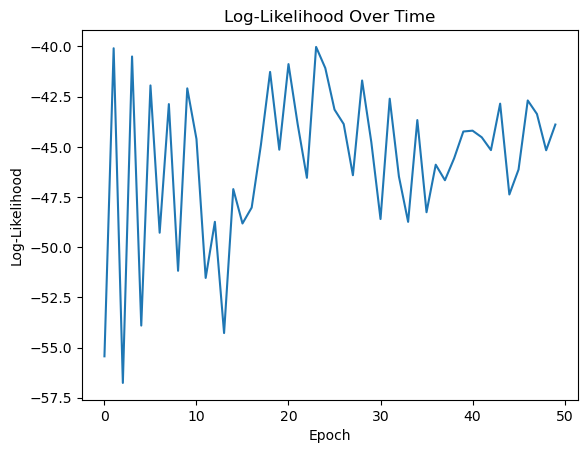

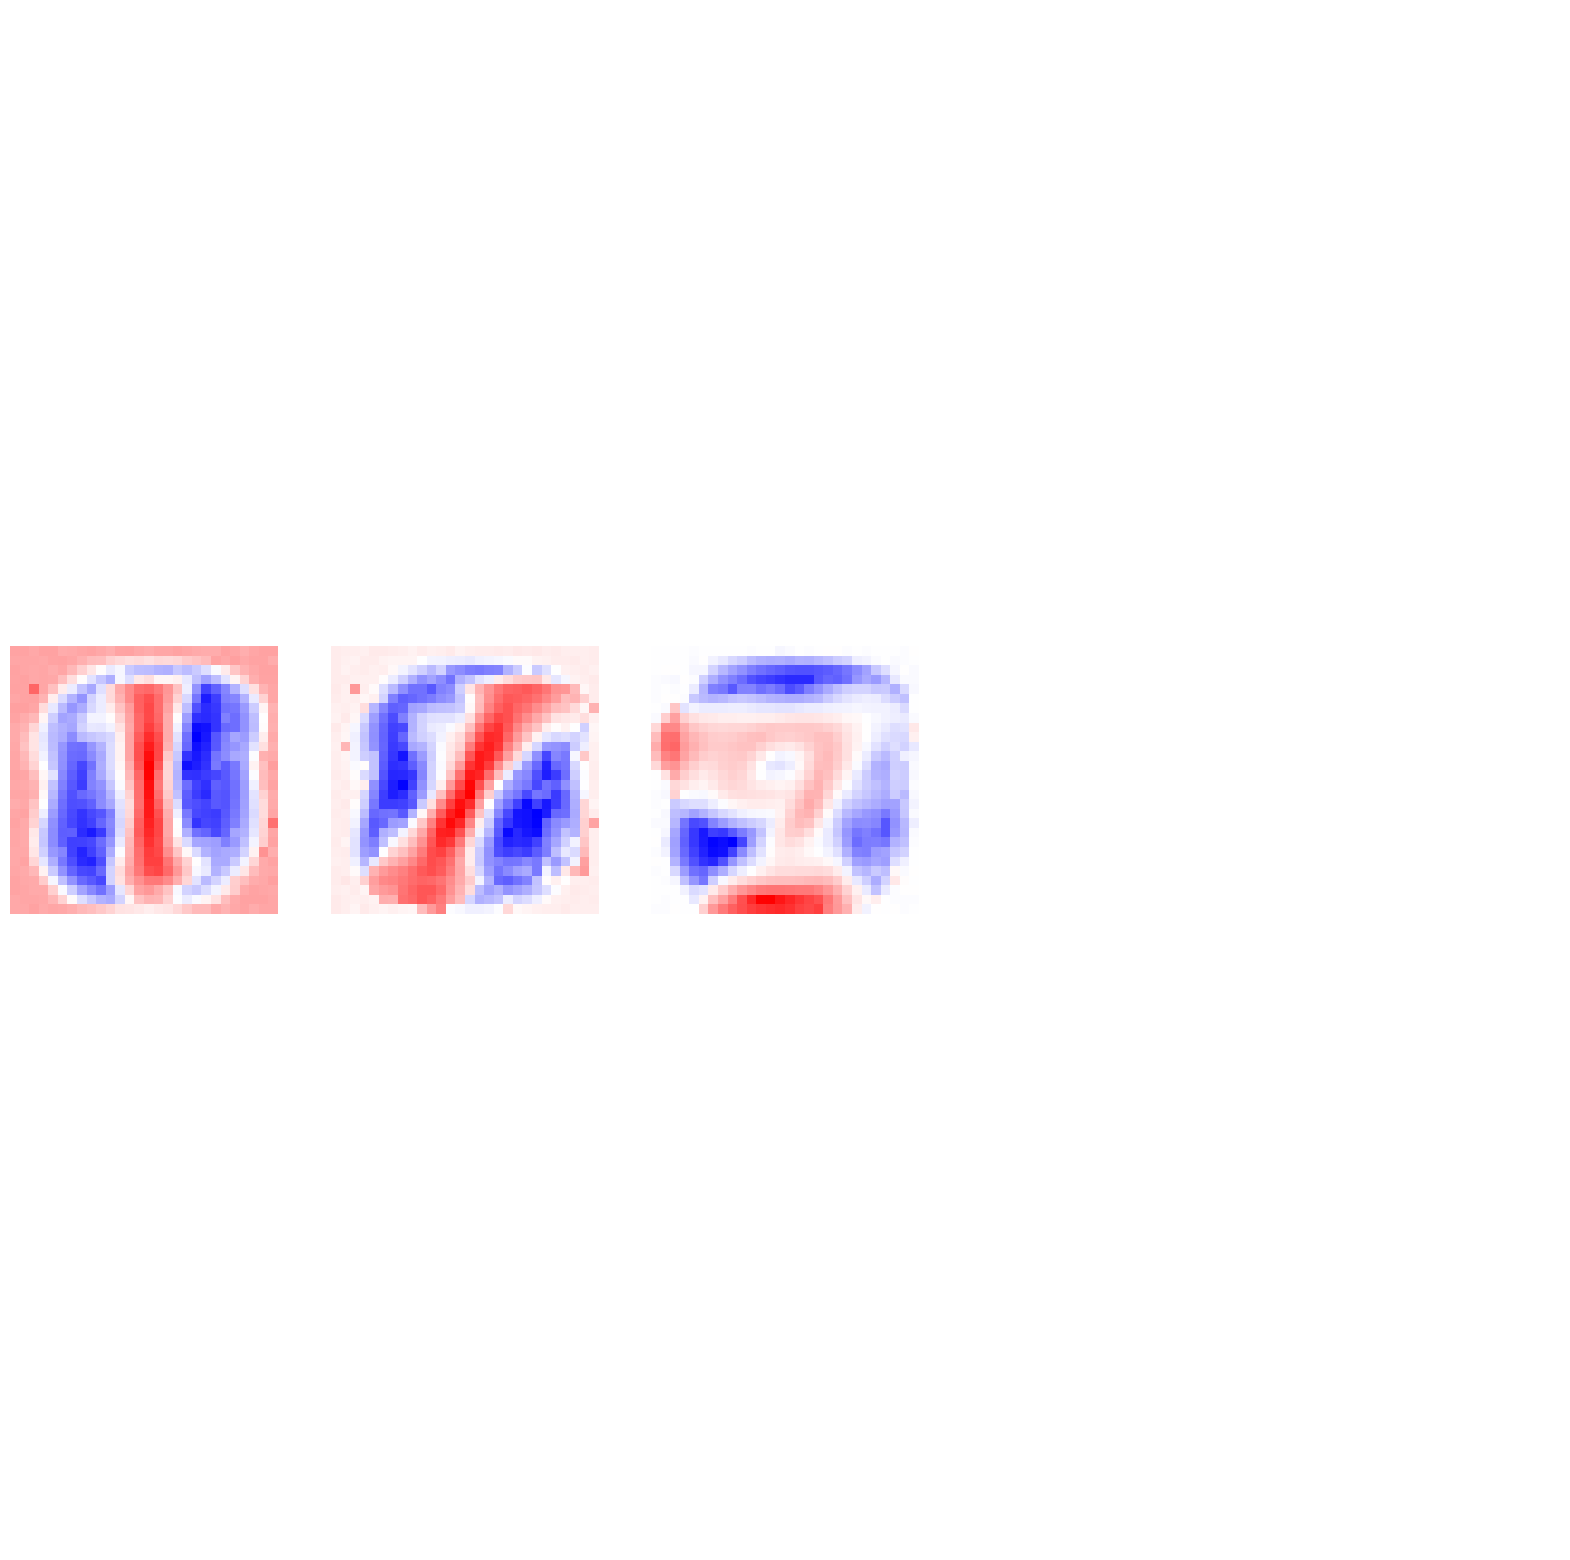

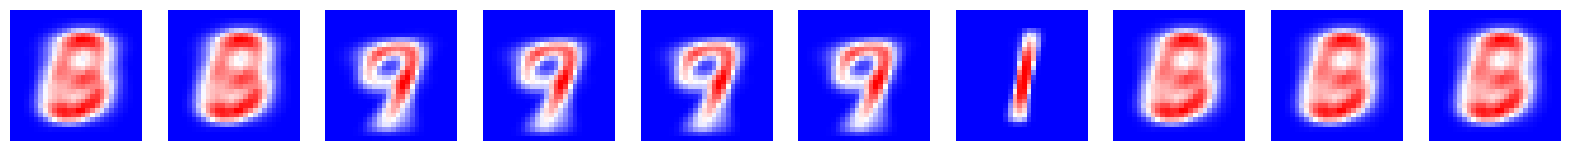

RBM training complete.


In [5]:
# Load data
X_original, Y_original = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

# Parameters
Ndigit = 10
L = 3
cd_steps = 1
Nepoch = 50
batch_size = 10

optimizer = 'SGD'

# Select data
list_10_digits = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
list_digits = list_10_digits[-Ndigit:]
keep = np.isin(Y_original, list_digits)
X_keep, Y = X_original[keep], Y_original[keep]

# Binarize data
binarizer = Binarizer(threshold=127.5)
data = binarizer.fit_transform(X_keep)

# Initialize and train the RBM
rbm = RBM(n_visible=data.shape[1], n_hidden=L, batch_size=batch_size, n_iter=Nepoch, optimizer=optimizer, cd_steps=cd_steps)
rbm.fit(data)

rbm.plot_learning_rate()
rbm.plot_log_likelihood()
# Define function to visualize the weights
def plot_weights(rbm, cols):
    fig, axes = plt.subplots(nrows=int(np.ceil(rbm.weights.shape[1]/cols)), ncols=cols, figsize=(20, 20))
    for i, ax in enumerate(axes.flatten()):
        if i < rbm.weights.shape[1]:
            ax.imshow(rbm.weights[:, i].reshape(28, 28), cmap='bwr')
        ax.axis('off')
    plt.show()

# Plot the weights
plot_weights(rbm, cols=5)

# Sample from the RBM
samples = rbm.transform(data)

# Ensure samples have the correct shape for reshaping into 28x28 images
samples = np.dot(samples, rbm.weights.T) + rbm.visible_bias
samples = rbm._sigmoid(samples)

# Plot samples
def plot_samples(samples, n_samples=10):
    fig, axes = plt.subplots(nrows=1, ncols=n_samples, figsize=(20, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i].reshape(28, 28), cmap='bwr')
        ax.axis('off')
    plt.show()

plot_samples(samples[:10])

print("RBM training complete.")

<Figure size 640x480 with 0 Axes>

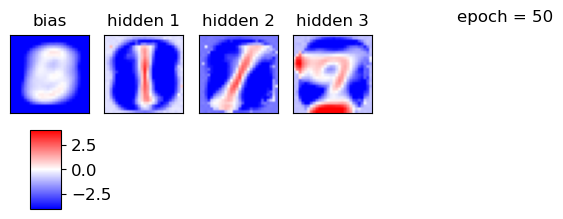

In [6]:
# import numpy as np
import matplotlib.pyplot as plt

def plot_weights_bias(rbm, epoch, L, 
                      side=0, cols=0, thr=0, s=1.2, 
                      title=False, save=True, cmap="bwr"):
    '''
    Plot the weights of the RBM, one plot for each hidden unit.
    '''
    rows = int(np.ceil(L / cols))
    if rows == 1: rows = 2
    w = rbm.weights
    b = rbm.visible_bias
    if side == 0: side = int(np.sqrt(len(w)))
    if thr == 0: thr = 4
    plt.clf()
    fig, AX = plt.subplots(rows, cols + 1, figsize=(s * (1 + cols), s * rows))
    if title: fig.suptitle(f"epoch = {epoch}")
    k = 1
    for i in range(rows):
        for j in range(cols):
            if rows == 1: ax = AX[j + 1]
            else: ax = AX[i, j + 1]
            if k <= L:
                ax.imshow(w[:, k - 1].reshape(side, side), cmap=cmap, vmin=-thr, vmax=thr)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title(f"hidden {k}")
            else: fig.delaxes(ax)
            k += 1
        if i > 0:  fig.delaxes(AX[i, 0])
    
    ax = AX[0, 0]
    im = ax.imshow(b.reshape(side, side), cmap=cmap, vmin=-thr, vmax=thr)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("bias")
    # colobar
    cbar_ax = fig.add_axes([0.14, 0.15, 0.024, 0.33])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=12)
    
    S = 0.3
    plt.subplots_adjust(hspace=S)

    if save: plt.savefig(f"./FIG/FRAME/RBM_{epoch}_w-a.png")

    plt.show()
    plt.close()

# Example usage
plot_weights_bias(rbm, epoch=50, L=L, cols=10, title=True)